In [68]:
import yaml

device = 'cpu'
hyp = 'data/hyps/hyp.scratch-low.yaml'

with open(hyp, errors="ignore") as f:
    hyp = yaml.safe_load(f)  # load hyps dict

### 원본 이미지
원본 이미지에 labeled box 처리

datasets/kaist-rgbt/train/labels/set05_V000_I01219.txt
datasets/kaist-rgbt/train/images/lwir/set05_V000_I01219.jpg
datasets/kaist-rgbt/train/images/visible/set05_V000_I01219.jpg
512 640
512 640
[[          0     0.14219      0.4082     0.12969     0.38086           0]
 [          0     0.27969     0.41992     0.12188     0.35938           0]]
[[          0          91         209          83         195           0]
 [          0         179         215          78         184           0]]
[[ 91 209 174 404]
 [179 215 257 399]]


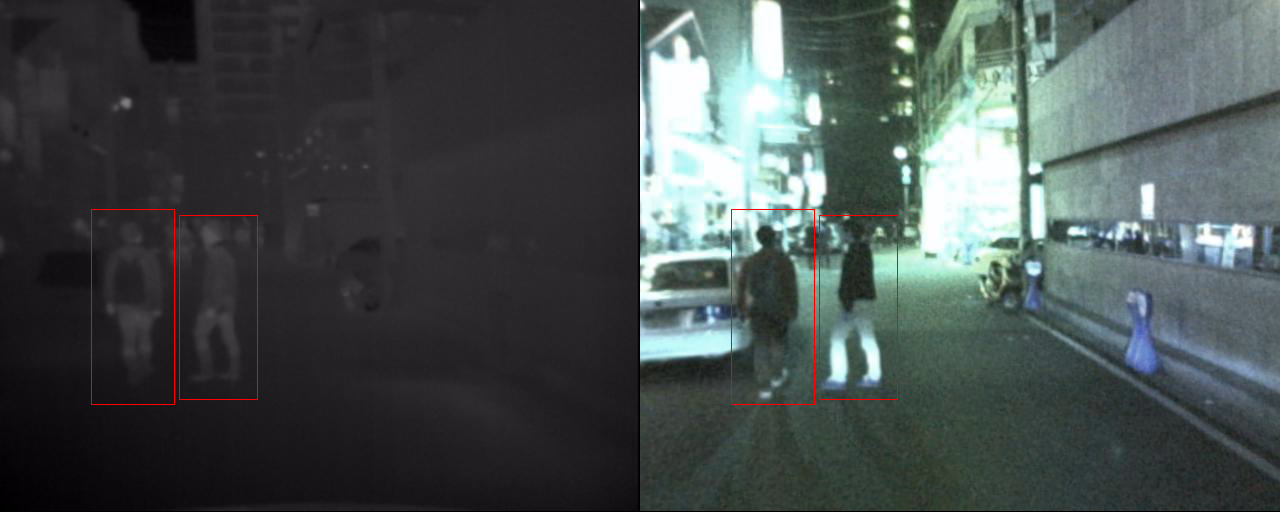

In [69]:
import cv2
import os
import numpy as np
from PIL import Image

annFile = 'datasets/kaist-rgbt/train/labels/set05_V000_I01219.txt'
# annFile = 'datasets/kaist-rgbt/train/labels/set01_V001_I00895.txt' # people
lwirFile = annFile.replace('labels', 'images/lwir').replace('.txt', '.jpg')
visFile  = annFile.replace('labels', 'images/visible').replace('.txt', '.jpg')
print(annFile)
print(lwirFile)
print(visFile)

# Read images
img_lwir = cv2.imread(lwirFile)
img_vis  = cv2.imread(visFile)

h, w = img_vis.shape[:2]
print(h, w)
h, w = img_lwir.shape[:2]
print(h, w)

# Read labels
with open(annFile, 'r') as fp:
    labels = [x.split() for x in fp.read().strip().splitlines() if len(x)]

# bt : labels (noramilzed된 길이)
# 0 : class, 1 : 시작 x, 2 : 시작 y, 3 : 폭, 4 : 높이, 5 : ?

colors = {
    0: (255, 0, 0),
    1: (0, 255, 0),
    2: (0, 0, 255),
    3: (255, 0, 255),
}

if len(labels):
    # convert normalized bbox to pixel coordinates
    labels = np.array(labels, dtype=np.float32)
    print(labels)
    labels[:, (1, 3)] *= w
    labels[:, (2, 4)] *= h
    print(labels)

    cls = labels[:, 0]

    xyxy = np.zeros((len(labels), 4))
    xyxy[:, :2] = labels[:, 1:3]
    xyxy[:, 2:] = labels[:, 1:3] + labels[:, 3:5]
    xyxy = xyxy.astype(np.int16)
    print(xyxy)

    for c, bb in zip(cls, xyxy):
        color = colors[c]
        cv2.rectangle(img_lwir, bb[:2], bb[2:], color)
        cv2.rectangle(img_vis,  bb[:2], bb[2:], color)

images = np.concatenate([img_lwir, img_vis], axis=1)
Image.fromarray(images)

### preprocssed 이미지
실제 preprocess를 통해 input으로 들어가는 이미지에 labeled box 처리

In [70]:
from utils.dataloaders import create_dataloader
from utils.general import check_img_size, colorstr
from utils.general import check_dataset
from models.yolo import Model

cfg = 'models/yolov5n_kaist-rgbt.yaml'
data = 'data/kaist-rgbt.yaml'
data_dict = check_dataset(data)

imgsz = 640
# bt : h, w중 큰 w가 640이라 거기에 맞춰 정사각형으로 input 이미지를 만드는 듯

batch_size = 1
single_cls = False
seed = 0

nc = int(data_dict["nc"])  # number of classes
train_path = data_dict["train"]

# bt : 사실 model 없어도 돌아감, gs도 어차피 수동으로 넣는 값이기 때문 
# model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create

# gs = max(int(model.stride.max()), 32)  # grid size (max stride)
# # gt : 기본으로 YOLOv5는 default로 3개 anchor쓰고 그 중 가장 큰게 32 (따라서 16, 8로 설정)

# imgsz = check_img_size(imgsz, gs, floor=gs * 2)  # verify imgsz is gs-multiple
# # gs의 배수인지 확인하면서 그 값의 배수로 조정 (floor는 그냥 최소 이상인지 확인)
gs = 32

train_loader, dataset = create_dataloader(
    train_path,
    imgsz,
    batch_size,
    gs,
    single_cls,
    hyp=hyp,
    augment=False,      # TODO: check if there is no bug when applying augmentation
    cache=None,
    rect=False,
    rank=-1,
    workers=8,
    image_weights=False,
    quad=False,
    prefix=colorstr("train: "),
    shuffle=False,      # No shuffle for debugging
    seed=seed,
    rgbt_input=True,
)


train: Scanning C:\Users\dlqud\Desktop\AUE8088\datasets\kaist-rgbt\train-all-04.cache... 12538 images, 7009 backgrounds, 0 corrupt: 100%|██████████| 12538/12538 [00:00<?, ?it/s]


[[          0           2    0.090625     0.50078       0.175     0.12969]]
[[          2    0.090625     0.50078       0.175     0.12969]]
[[  2 279 114 362]]
datasets\kaist-rgbt\train\images\{}\set01_V001_I00895.jpg


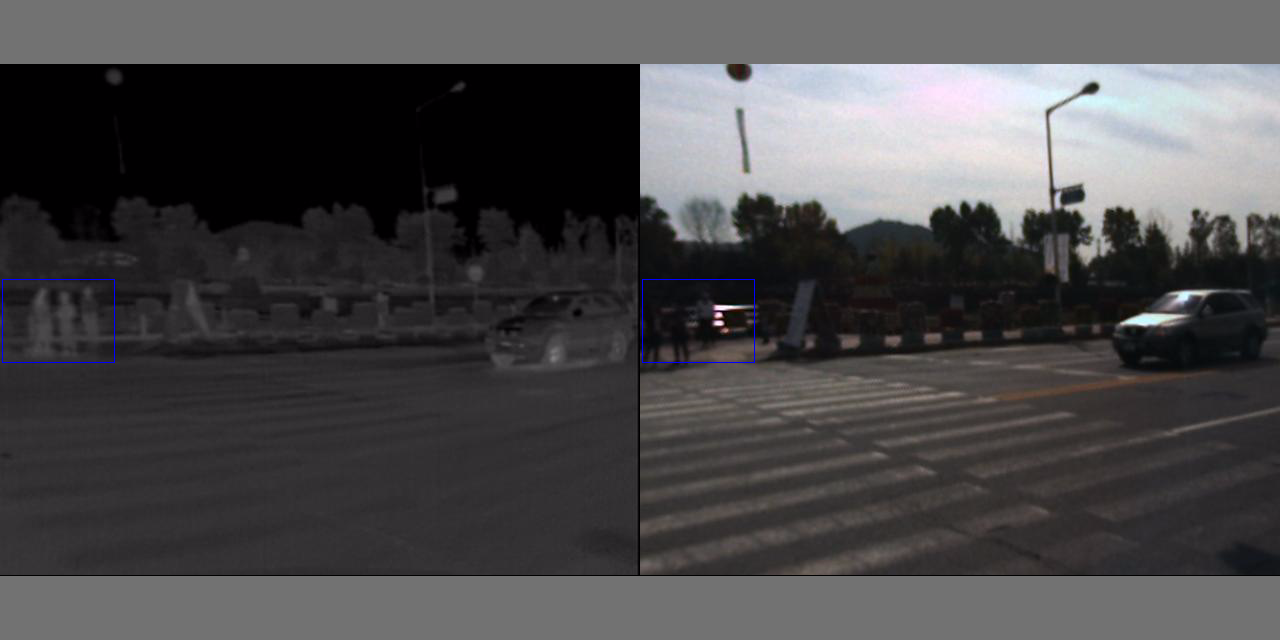

In [71]:
from utils.dataloaders import LoadRGBTImagesAndLabels
from utils.general import xywh2xyxy

# frame = 12112 # 위에서 같은 이미지에 해당하는 frame
frame = 5157 # people 이미지에 해당하는 frame

# Get a minibatch (fast)
imgs, targets, paths, shapes, _ = LoadRGBTImagesAndLabels.collate_fn([dataset[frame]])
# bt : target은 labeled box
# 1 : class, 2~5 normalized된 좌표, 길이 (원본 이미지에서랑 동일한 mechanism일 듯)

idx = 0
img_lwir = imgs[0][idx].numpy().transpose((1, 2, 0))
img_vis  = imgs[1][idx].numpy().transpose((1, 2, 0))
h, w = img_vis.shape[:2]
# print(h, w) : 640, 640

labels = targets.numpy()

colors = {
    0: (255, 0, 0),
    1: (0, 255, 0),
    2: (0, 0, 255),
    3: (255, 0, 255),
}

if len(labels):
    print(labels)
    labels = labels[labels[:, 0] == idx, 1:]
    print(labels)

    # convert normalized bbox to pixel coordinates
    labels = np.array(labels, dtype=np.float32)
    labels[:, (1, 3)] *= w
    labels[:, (2, 4)] *= h

    cls = labels[:, 0]

    xyxy = xywh2xyxy(labels[:, 1:5])
    xyxy = xyxy.astype(np.int16)
    
    print(xyxy)

    img_lwir = np.ascontiguousarray(img_lwir)
    img_vis = np.ascontiguousarray(img_vis)

    for c, bb in zip(cls, xyxy):
        color = colors[c]
        cv2.rectangle(img_lwir, bb[:2], bb[2:], color)
        cv2.rectangle(img_vis,  bb[:2], bb[2:], color)

images = np.concatenate([img_lwir, img_vis], axis=1)
print(paths[idx])
Image.fromarray(images)

### 훈련된 모델로 실행

In [72]:
import torch
from utils.torch_utils import select_device

weights = 'kaist-rgbt_best.pt'      # Train your own model!
data = 'data/kaist-rgbt.yaml'
cfg = 'models/yolov5s_kaist-rgbt.yaml'
hyp = 'data/hyps/hyp.scratch-low.yaml'
nc = 1 # bt : 우리는 multi가 아닌 그냥 classification
half = False  # use FP16 half-precision inference
dnn = False  # use OpenCV DNN for ONNX inference
device = select_device('cpu')

with open(hyp, errors="ignore") as f:
    hyp = yaml.safe_load(f)  # load hyps dict

model = Model(cfg, ch=3, nc=nc, anchors=hyp.get("anchors")).to(device)  # create

# 여기 아마 train한 모델의 weight를 load

# inference
model.eval()
ims = [im.to(device, non_blocking=True).float() / 255 for im in imgs]    # For RGB-T input
with torch.no_grad():
    pred = model(ims)  # forward


YOLOv5  bddaf3c Python-3.10.18 torch-2.7.1+cu126 CPU


                 from  n    params  module                                  arguments                     
  0                -1  1      7040  models.common.MultiStreamConv           [3, 32, 6, 2, 2]              
  1                -1  1     37120  models.common.MultiStreamConv           [32, 64, 3, 2]                
  2                -1  1     37632  models.common.MultiStreamC3             [64, 64, 1]                   
  3                -1  1         0  models.common.Fusion                    ['concat', 2]                 
  4                -1  1     16640  models.common.Conv                      [128, 128, 1, 1]              
  5                -1  1    147712  models.common.Conv                      [128, 128, 3, 2]              
  6                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  7                -1  1    295424  models.common.Conv                      [128, 256, 3,

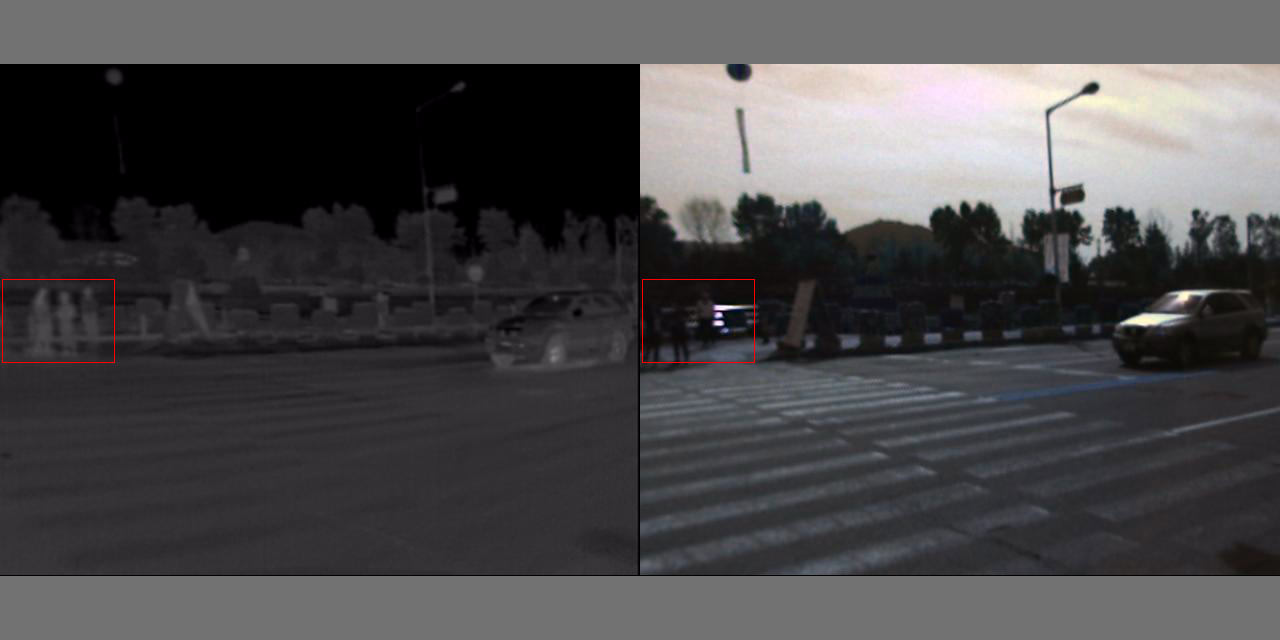

In [ ]:
from utils.general import scale_boxes, non_max_suppression

conf_thres = 0.25  # confidence threshold
iou_thres = 0.45  # NMS IOU threshold
max_det = 1000  # maximum detections per image
classes = None 
agnostic_nms = False  # class-agnostic NMS

pred_temp = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)

# --------------------------------------------------
# ↓ 여기부터 추가 (pred 위는 건드리지 마세요)
# --------------------------------------------------

# 1) Non-max suppression 결과 중 첫 번째(배치 0)만 꺼내기
pred0 = pred_temp[0]  # shape (num_preds, 6): [x1,y1,x2,y2,conf,cls]

# 2) 모델 입력 크기와 원본 이미지 정보
#    imgs[0] 은 LWIR 텐서, imgs[1] 은 Visible 텐서, (B,C,H,W)
#    shapes[idx] = ((orig_h, orig_w), (gain, pad))
img1_shape      = imgs[0].shape[2:]      # (H_model, W_model)
img0_shape, pad = shapes[idx]            # ((H_orig,W_orig), (gain,pad))

# 3) 스케일 보정: 모델 입력 좌표 → 원본 이미지 좌표
scale_boxes(img1_shape, pred0[:, :4], img0_shape, pad)

# 4) NumPy 이미지 복사본 준비 (cv2.rectangle 그리기용)
img_lwir_np = img_lwir.copy()
img_vis_np  = img_vis.copy()
# 아까 그린걸 복사해서 labeling box가 그려짐 

# 5) 예측 박스 그리기
for *xyxy, conf, cls in pred0.cpu().tolist():
    x1, y1, x2, y2 = map(int, xyxy)
    print(f"[Det {i}] cls={int(cls)}, conf={conf:.3f}, x1={x1:.1f}, y1={y1:.1f}, x2={x2:.1f}, y2={y2:.1f}")
    color = colors[int(cls)]
    # LWIR / Visible 모두에 박스 그리기
    cv2.rectangle(img_lwir_np, (x1, y1), (x2, y2), color, 2)
    cv2.rectangle(img_vis_np,  (x1, y1), (x2, y2), color, 2)
    # (선택) 클래스명 + confidence 표시
    label = f"{int(cls)} {conf:.2f}"
    cv2.putText(img_vis_np, label, (x1, y1 - 6),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

# 6) 두 채널 이미지를 붙여서 출력
combined = np.concatenate([img_lwir_np, img_vis_np], axis=1)
Image.fromarray(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
# --------------------------------------------------
# ↑ 여기까지 추가
# --------------------------------------------------

